In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


df_all = pd.concat([train.assign(ind = "train"), test.assign(ind = "test")])

In [3]:
#df_all.head()
#df_all.info()

In [4]:
# Удаление признаков с постоянными значениями
constant_features = [col for col in df_all.columns if df_all[col].nunique() == 1]
df_all = df_all.drop(columns=constant_features)

# Удаление признаков с уникальными значениями
unique_features = [col for col in df_all.columns if df_all[col].nunique() == len(df_all)]
df_all = df_all.drop(columns=unique_features)


numeric = [i for i in df_all.columns if df_all[i].dtype != 'object' and i != 'SalePrice']
categ = [i for i in df_all.columns if df_all[i].dtype == 'object']


#df_all.info()

<Axes: >

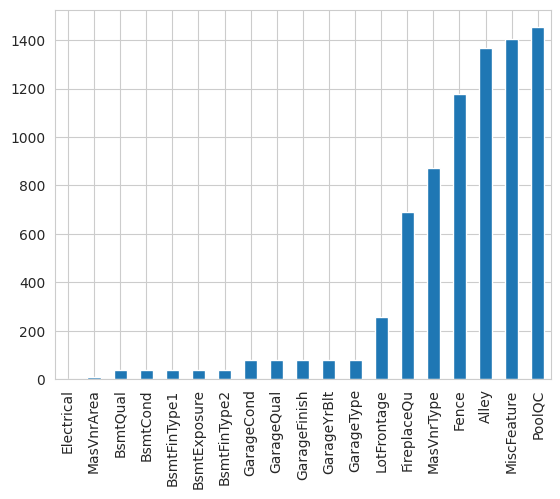

In [5]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

/tmp/ipykernel_17/1997198390.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/tmp/ipykernel_17/1997198390.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.norm)
/tmp/ipykernel_17/1997198390.py:9: UserWarning: 

`distplot` is a dep

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

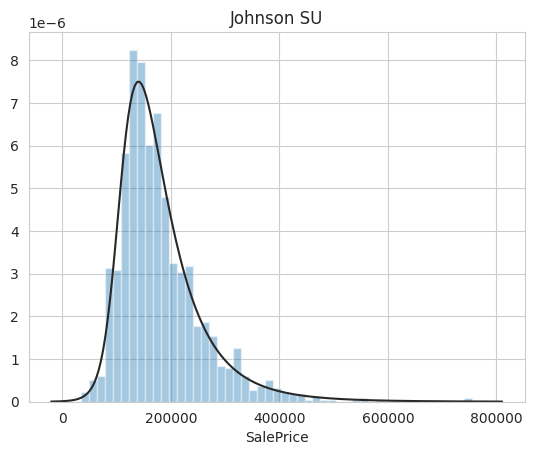

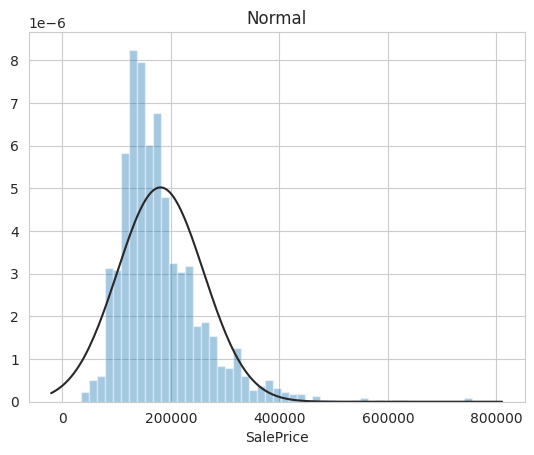

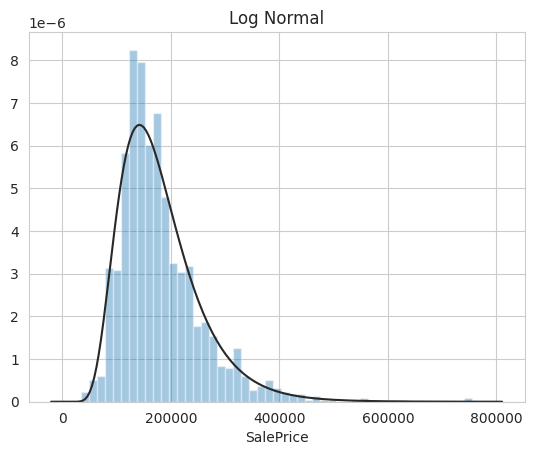

In [6]:
import scipy.stats as stats

y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [7]:
# Логарифмирование 'SalePrice' для тренировочных данных
df_all.loc[df_all["ind"] == "train", "SalePrice"] = np.log1p(df_all.loc[df_all["ind"] == "train", "SalePrice"])

# Перенос значений 'SalePrice' в переменную y (с очисткой индекса)
y = df_all['SalePrice'].reset_index(drop=True)

In [8]:
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)
df_all['Functional'] = df_all['Functional'].fillna('Typ') 
df_all['Electrical'] = df_all['Electrical'].fillna("SBrkr") 
df_all['KitchenQual'] = df_all['KitchenQual'].fillna("TA") 
df_all["PoolQC"] = df_all["PoolQC"].fillna("None")
df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0]) 
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])



for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_all[col] = df_all[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_all[col] = df_all[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all[col] = df_all[col].fillna('None')


df_all['MSZoning'] = df_all.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


In [9]:
df_all['LotFrontage'] = df_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))



df_all['YrBltAndRemod']=df_all['YearBuilt']+df_all['YearRemodAdd']
df_all['TotalSF']=df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

df_all['Total_sqr_footage'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] +
                                 df_all['1stFlrSF'] + df_all['2ndFlrSF'])

df_all['Total_Bathrooms'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))

df_all['Total_porch_sf'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                              df_all['EnclosedPorch'] + df_all['ScreenPorch'] +
                              df_all['WoodDeckSF'])



df_all['haspool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['has2ndfloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasgarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasbsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasfireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
for i in df_all.select_dtypes(include=['object']).columns:
    df_all[i] = df_all[i].fillna('None')

for i in df_all.select_dtypes(include=['number']).columns:
    df_all[i] = df_all[i].fillna(0)

In [11]:
numeric = [i for i in df_all.columns if df_all[i].dtype != 'object' and i != 'SalePrice']
categ = [i for i in df_all.columns if df_all[i].dtype == 'object']

categ.remove('ind')

In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 91 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2919 non-null   object 
 1   MSZoning           2919 non-null   object 
 2   LotFrontage        2919 non-null   float64
 3   LotArea            2919 non-null   int64  
 4   Street             2919 non-null   object 
 5   Alley              2919 non-null   object 
 6   LotShape           2919 non-null   object 
 7   LandContour        2919 non-null   object 
 8   Utilities          2919 non-null   object 
 9   LotConfig          2919 non-null   object 
 10  LandSlope          2919 non-null   object 
 11  Neighborhood       2919 non-null   object 
 12  Condition1         2919 non-null   object 
 13  Condition2         2919 non-null   object 
 14  BldgType           2919 non-null   object 
 15  HouseStyle         2919 non-null   object 
 16  OverallQual        2919 non-n

## Иерархическое кодирование

In [13]:
def encode_inplace(frame, feature):
    # Рассчитываем среднее значение SalePrice для каждой категории
    spmean = frame.groupby(feature)['SalePrice'].mean()
    
    # Присваиваем порядковые значения на основе сортировки
    ordering = spmean.sort_values().rank().to_dict()
    
    # Заменяем оригинальный столбец закодированным значением
    frame[feature] = frame[feature].map(ordering)


for q in df_all[categ]:
    encode_inplace(train, q)

In [14]:
df_all = pd.get_dummies(df_all, columns = categ)

## Ассиметрия

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox
from scipy.special import boxcox1p

# Рассчитываем асимметрию для числовых столбцов
skew_features = df_all[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Выбираем столбцы с высокой асимметрией
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

# Применяем Box-Cox преобразование для столбцов с высокой асимметрией
for i in skew_index:
    if pd.api.types.is_numeric_dtype(df_all[i]):
        # Применяем boxcox1p, чтобы избежать проблем с нулями или отрицательными значениями
        df_all[i] = boxcox1p(df_all[i], 0)  # Параметр 0 соответствует преобразованию, аналогичному Box-Cox


## Нормализация

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Нормализация всех числовых столбцов
df_all[numeric] = scaler.fit_transform(df_all[numeric])

## Model

In [17]:
# Подготовка тренировочных данных и целевого вектора
X = df_all[df_all['ind'] == 'train'].drop(columns=['SalePrice', 'ind'])
y = df_all[df_all['ind'] == 'train']['SalePrice']

# Кросс-валидация
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


In [18]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [19]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))     

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [20]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   

In [21]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [22]:
xgboost = XGBRegressor(
    learning_rate=0.01,
    n_estimators=3460,
    max_depth=3,
    min_child_weight=0,
    gamma=0,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:squarederror',  # Обновление параметра
    nthread=-1,
    scale_pos_weight=1,
    seed=27,
    reg_alpha=0.00006
)


In [23]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [24]:
# Кросс-валидация для каждой модели
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


LASSO: 0.1218 (0.0274)
 2024-11-20 15:12:19.389685
elastic net: 0.1218 (0.0274)
 2024-11-20 15:14:38.213621
SVR: 0.1238 (0.0312)
 2024-11-20 15:14:43.802639
lightgbm: 0.1202 (0.0190)
 2024-11-20 15:15:13.232186
gbr: 0.1209 (0.0239)
 2024-11-20 15:17:32.889226
xgboost: 0.1173 (0.0199)
 2024-11-20 15:18:52.118414


In [25]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
lightgbm


In [26]:
X_test = df_all[df_all['ind'] == 'test'].drop(columns=['SalePrice', 'ind'])

In [27]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [28]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.06309386483305568


In [29]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_test)))

Predict submission
